In [54]:
from datasets import load_dataset
from torch.utils.data import DataLoader 
import matplotlib.pyplot as plt
import os
from torch import nn
import torch
from tqdm.auto import tqdm
from pathlib import Path
import wandb
import albumentations
from torchvision.transforms import Compose, Resize, ToTensor, Grayscale, ToPILImage 

In [55]:
dataset_transformations = Compose([
    Resize(size=(360, 360)),
    ToTensor()
])

# Function to apply transformations
def apply_transforms(data):
    data["image"] = [ToPILImage()(image) for image in data["image"]]  # Convert tensors to PIL Images
    data["image"] = [dataset_transformations(image) for image in data["image"]]
    return data

In [56]:
"""
0 - Glioma Tumor
1 - Meningioma Tumor
2 - Pituitary Tumor
3 - No Tumor
"""

dataset = load_dataset("sartajbhuvaji/Brain-Tumor-Classification")
dataset = dataset.with_format("torch")

In [58]:
dataset = dataset.map(apply_transforms)

Map:  20%|██        | 585/2870 [04:20<18:16,  2.08 examples/s]

: 

In [21]:
dataset["Training"].num_rows

2870

In [47]:
dataset["Training"]["label"]

{'label': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

KeyError: 'image'

In [13]:
classes = ["Glioma Tumor", "Meningioma Tumor", "Pituitary Tumor", "No Tumor"]

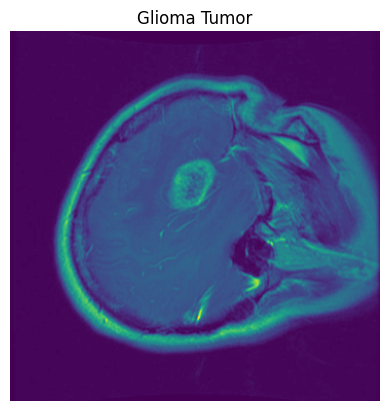

In [14]:
index = 5
img = dataset["Training"][index]["image"]
img = img.T
plt.imshow(img)
plt.title(classes[dataset["Training"][index]["label"]])
plt.axis("off")
plt.show()

In [11]:
img.shape

torch.Size([360, 360, 1])

In [12]:
NUM_WORKERS = 0
BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset=dataset["Training"],
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=dataset["Testing"],
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

In [13]:
train_dataloader.dataset[0]
data = []
data.append([train_dataloader.dataset[0]["image"], train_dataloader.dataset[0]["label"]])
data

[[tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]),
  0]]

In [14]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [15]:
class model_v0(nn.Module):
    def __init__(self, kernel: int, padding: int, stride: int):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=kernel, padding=padding, stride=stride),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=kernel, padding=padding, stride=stride)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=kernel, padding=padding, stride=stride),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=kernel, padding=padding, stride=stride)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.ReLU(),
            # nn.Linear(518400, 1)
        )
    def forward(self, x):
        x = self.classifier(self.layer1(self.layer2(x)))
        print(x.shape)
        return x

In [16]:
def train(model: torch.nn.Module,
        #   writer,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader:  torch.utils.data.DataLoader,
          project_name: str,
          learning_rate: int,
          dataset: str,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          device,
          loss_function_name,
          revision,
          optimizer_name,
        #   model_input_size: torch.randn, #torch.randn(32, 1, 28, 28)
          epochs: int = 10,
          save_model: bool = False,
          save_model_path: str = "./models",
          model_name: str = "model"):

    wandb.init(
        project=project_name,
        config={
            "learning_rate": learning_rate,
            "revision": revision,
            "dataset": dataset,
            "epochs": epochs,
            "loss_function": loss_function_name,
            "optimizer_name": optimizer_name
        }
    )

    for epoch in tqdm(range(epochs)):
        # Put the model in train mode
        model.to(device)
        model.train()

        # Setup train loss and train accuracy values
        train_loss, train_acc = 0, 0

        for batch, (X, y) in enumerate(train_dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # Forward pass
            y_pred = model(X)

            # Calculate and accumulate loss 
            loss = loss_fn(y_pred, y)
            train_loss += loss.item()

            # Optimizer zero grad
            optimizer.zero_grad()

            # Loss backward
            loss.backward()

            # Optimizer step
            optimizer.step()

            # Calculate and accumulate accuray metrics across all batches
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            train_acc += (y_pred_class == y).sum().item()/len(y_pred)

        # Adjust metrics to get average loss and accuracy per batch
        train_loss = train_loss / len(train_dataloader)
        train_acc = train_acc / len(train_dataloader)

        # Put the model in eval mode
        model.to(device)
        model.eval()

        # Setup test loss and test accuracy values
        test_loss, test_acc = 0, 0

        with torch.inference_mode():
            # Loop through DataLoader batches
            for batch, (X, y) in enumerate(test_dataloader):
                # Send data to target deivce
                X, y = X.to(device), y.to(device)

                # Forward pass
                test_pred_logits = model(X)

                # Calculate and accumulate loss
                loss = loss_fn(test_pred_logits, y)
                test_loss += loss.item()

                # Calculate and accumulate accuracy
                test_pred_labels = test_pred_logits.argmax(dim=1) 
                test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))

            # Adjust metrics to get average loss and accuracy per batch
            test_loss = test_loss / len(train_dataloader)
            test_acc = test_acc / len(test_dataloader)
            
            results = {"train_loss": [],
                        "train_acc": [],
                        "test_loss": [],
                        "test_acc": []}
            print(
                    f"Epoch: {epoch+1} | "
                    f"train_loss: {train_loss:.4f} | "
                    f"train_acc: {train_acc:.4f} | "
                    f"test_loss: {test_loss:.4f} | "
                    f"test_acc: {test_acc:.4f}")
            results["train_loss"].append(train_loss)
            results["train_acc"].append(train_acc)
            results["test_loss"].append(test_loss)
            results["test_acc"].append(test_acc)

            wandb.log({"train_loss": train_loss, "train_acc": train_acc, "test_loss": test_loss, "test_acc": test_acc})

            # writer.add_scalar(tag="Train Loss",
            #                   scalar_value=train_loss,
            #                   global_step=epoch)

            # writer.add_scalar(tag="Train Accuracy",
            #                   scalar_value=train_acc,
            #                   global_step=epoch)             

            # writer.add_scalar(tag="Test Loss",
            #                   scalar_value=test_loss,
            #                   global_step=epoch) 
            # writer.add_scalar(tag="Test Accuracy",
            #                   scalar_value=test_acc,
            #                   global_step=epoch) 
            # writer.add_graph(model=model,
            #                  input_to_model=model_input_size.to(device))
    if save_model == True:
        print(f"[INFO] Saving {model_name} model to {save_model_path}")
        MODEL_PATH = Path(save_model_path) 
        MODEL_PATH.mkdir(parents=True,
                         exist_ok=True)
        MODEL_SAVE_PATH = MODEL_PATH/model_name
        torch.save(obj=model.state_dict(),
                   f=MODEL_SAVE_PATH)
        wandb.finish()
        return results
    else:
        wandb.finish()
        return results

In [17]:
SEED = 42
MODEL_NAME = "Model V0"
LOSS_FUNCTION_NAME = "Cross Entropy Loss"
OPTIMIZER_NAME = "Adam"
EPOCHS = 10
LEARNING_RATE = 0.01
REVISION = 1
PROJECT_NAME = "Model V0 Revision 1"
DATASET = "Brain Tumour"


torch.manual_seed(SEED)
torch.mps.manual_seed(SEED)

model_v0 = model_v0(4, 0, 1).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_v0.parameters(), lr=LEARNING_RATE)


train(
    model=model_v0,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    project_name=PROJECT_NAME,
    learning_rate=LEARNING_RATE,
    dataset=DATASET,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device,
    loss_function_name=LOSS_FUNCTION_NAME,
    revision=REVISION,
    optimizer_name=OPTIMIZER_NAME,
    epochs=EPOCHS,
    save_model=False,
    save_model_path="./model",
    model_name=MODEL_NAME
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: pypdeveloper. Use `wandb login --relogin` to force relogin


  0%|          | 0/10 [00:00<?, ?it/s]


AttributeError: 'str' object has no attribute 'to'

In [84]:
model_v0 = model_v0(kernel=4, padding=0, stride=1).to(device)

model_v0.eval()
model_v0(img.transpose(2,0))

RuntimeError: Given groups=1, weight of size [64, 64, 4, 4], expected input[1, 1, 360, 360] to have 64 channels, but got 1 channels instead

torch.Size([1, 360, 360])